## Building up tVMC

Next step - Fix KE calculation for complex psis, make it consistent with the analytical model

In [1]:
%load_ext autoreload
%autoreload 3

In [7]:
import jax
import jax.numpy as jnp
from sampling import metropolis_step
from local_energy import get_local_energy_fn
import matplotlib.pyplot as plt

In [8]:
key = jax.random.key(seed=3)
pos = jax.random.normal(key, (4200, 3))

### Hydrogen superposition - relative phase beating mode

In [299]:
def f(params, x):
    """
    Wavefunction representing the superposition of the ground and first excited state of Hydrogen.
    The time dependent parameter controls the relative phase evolution.
    """
    r = jnp.linalg.norm(x)
    c1 = 1/jnp.sqrt(jnp.pi)
    c2 = 1/(4 * jnp.sqrt(2 * jnp.pi))
    norm_factor_c1 = jnp.sqrt((1 - c2 ** 2)/(c1 ** 2))
    return norm_factor_c1 * c1 * jnp.exp(-r) * jnp.exp(1j * params.squeeze()) + c2 * jnp.exp(-r/2) * (2 - r)

batched_f = jax.jit(jax.vmap(f, in_axes=(None, 0)))

In [290]:
def k(x):
    c1 = 1/jnp.sqrt(jnp.pi)
    c2 = 1/(4 * jnp.sqrt(2 * jnp.pi))
    r = jnp.linalg.norm(x)
    return -c1 * 1j * jnp.exp(-r) * jnp.exp(1j * params.squeeze())
    

def f(params, x):
    """
    Wavefunction representing the superposition of the ground and first excited state of Hydrogen.
    The time dependent parameter controls the relative phase evolution.
    """
    r = jnp.linalg.norm(x)
    c1 = 1/jnp.sqrt(jnp.pi)
    c2 = 1/(4 * jnp.sqrt(2 * jnp.pi))
    norm_factor_c1 = jnp.sqrt((1 - c2 ** 2)/(c1 ** 2))
    return norm_factor_c1 * c1 * jnp.exp(-r) * jnp.exp(1j * params.squeeze()) + c2 * jnp.exp(-r/2) * (2 - r)

In [279]:
c1 = 1/jnp.sqrt(jnp.pi)
c2 = 1/(4 * jnp.sqrt(2 * jnp.pi))
c1**2 * c2**2

Array(0.00316629, dtype=float32, weak_type=True)

In [ ]:
1/

In [308]:
c1 = 1/jnp.sqrt(jnp.pi)
c2 = 1/(4 * jnp.sqrt(2 * jnp.pi))
norm_factor_c1 = jnp.sqrt((1 - c2 ** 2)/(c1 ** 2))

In [310]:
c1**2 * c2**2 * norm_factor_c1**2 * 0.375

Array(0.00369309, dtype=float32, weak_type=True)

In [264]:
k_ = jax.vmap(k)

In [273]:
val = k_(pos)

In [274]:
val2 = val - jnp.mean(val)

In [276]:
jnp.dot(jnp.conj(val2).T, val2)/4200

Array(0.0153126+0.j, dtype=complex64)

In [270]:
jnp.conj(jnp.mean(k_(pos))) * jnp.mean(k_(pos))

Array(0.02465146+0.j, dtype=complex64)

In [230]:
1/jnp.pi

0.3183098861837907

In [258]:
jnp.dot(jnp.conj(o_alpha).T, o_alpha)/o_alpha.shape[0]

Array([[0.04018018+0.j]], dtype=complex64)

In [267]:
jnp.mean(o_alpha, axis=0, keepdims=True)

Array([[0.+0.15668197j]], dtype=complex64)

In [268]:
jnp.conj(o_alpha_mean) * o_alpha_mean

Array([[0.02454924+0.j]], dtype=complex64)

In [300]:
o_alpha = jax.jacfwd(lambda p: batched_f(p, pos))(params)
o_alpha_centered = o_alpha - jnp.mean(o_alpha)
o_alpha_mean = jnp.mean(o_alpha, axis=0, keepdims=True)

s = jnp.dot(jnp.conj(o_alpha).T, o_alpha)/o_alpha.shape[0] - jnp.conj(o_alpha_mean) * o_alpha_mean
#s = jnp.dot(jnp.conj(o_alpha).T, o_alpha_centered)/o_alpha.shape[0]

In [301]:
s

Array([[0.04762711+0.j]], dtype=complex64)

In [257]:
jax.jacfwd(lambda p: batched_f(p, pos))(params)

Array([[0.+1.3062352e-01j],
       [0.+1.7910509e-01j],
       [0.+2.3484595e-01j],
       ...,
       [0.+8.9527644e-02j],
       [0.+1.3265948e-04j],
       [0.+9.4097969e-04j]], dtype=complex64)

In [248]:
t= jax.vmap(jax.grad(f, argnums=0), in_axes=(None, 0))

In [236]:
o_alpha

Array([[0.+6.5606477e-04j],
       [0.+1.9640889e-04j],
       [0.+2.8290790e-01j],
       ...,
       [0.+5.5548176e-04j],
       [0.+2.2429755e-01j],
       [0.+1.1087608e-03j]], dtype=complex64)

In [240]:
jnp.dot(jnp.conj(o_alpha).T, o_alpha)/4200

Array([[0.04018018+0.j]], dtype=complex64)

In [243]:
1/jnp.pi

0.3183098861837907

In [207]:
o = o_alpha
o_mean = jnp.mean(o, axis=0, keepdims=True)
o_c = o - o_mean

s = (jnp.conj(o_c).T @ o_c) / o.shape[0]


In [113]:
params = jnp.array([0.0])

In [335]:
params = jnp.array([0.0])
te = get_local_energy_fn(f, 1, 1)

In [336]:
pos = jax.random.uniform(key, (10000, 3))

In [337]:
def get_energy_mean_variance(energies):
    me = jnp.mean(energies)
    var = jnp.mean((energies - me) ** 2)
    return me, var

In [338]:
mc_step = metropolis_step(params, batched_f, pos, key)

In [339]:
# Warmup steps
key, subkey = jax.random.split(key)
pos = jax.random.uniform(subkey, (4200, 3))

for i in range(100):
    key, subkey = jax.random.split(key)
    pos, pmove = mc_step(params, pos, subkey, mcmc_width=0.5)
print(pmove)

0.62680954


In [340]:
energies = te(params, pos)

In [341]:
get_energy_mean_variance(energies)

(Array(-0.42641604+0.j, dtype=complex64),
 Array(0.01910787+0.j, dtype=complex64))

In [342]:
k = energies - jnp.mean(energies)

In [343]:
dt = 1e-2

In [344]:
def get_update(params, pos):
    """Gets theta dot"""
    o_alpha = jax.jacfwd(lambda p: batched_f(p, pos))(params)
    o_alpha_centered = o_alpha - jnp.mean(o_alpha)
    s = jnp.mean(jnp.conj(o_alpha) * o_alpha_centered)
    #s += 1e-8
    energy = te(params, pos)
    energy_centered = energy - jnp.mean(energy)
    F_sup = jnp.dot(energy_centered, jnp.conjugate(o_alpha))/o_alpha.shape[0]
    F = -1j * 2 * F_sup
    theta_dot = jnp.real(F)/jnp.real(s)
    
    return theta_dot

update_fn = jax.jit(get_update)

In [345]:
energy = te(params, pos)

In [ ]:
dt = 1e-2

In [355]:

r_expect = []
for i in range(600):
    key, subkey = jax.random.split(key)
    pos = jax.random.uniform(subkey, (200, 3))

    for j in range(30):
        key, subkey = jax.random.split(key)
        pos, pmove = mc_step(params, pos, subkey, 0.5)
        
    theta_dot = get_update(params, pos)
    print(theta_dot)

    params = params + dt * theta_dot
    density = jnp.abs(batched_f(params, pos)) ** 2

    r = jnp.linalg.norm(pos, axis=1)
    r_exp = jnp.mean(r)
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)
    Eloc = te(params, pos)
    #r_expect.append(r_exp)
    #print(r_exp)
    if i % 2 == 0:
        print(f"Elocal {jnp.mean(Eloc)}")
        print(f"Evar {jnp.mean((Eloc - jnp.mean(Eloc)) ** 2)}")

[0.27907786]
Elocal (-0.4317491352558136-0.000386047235224396j)
Evar (0.029233340173959732-0.003779044607654214j)
[0.16694193]
[-0.01450088]
Elocal (-0.4534033238887787+0.00027311212033964694j)
Evar (0.008598964661359787+5.8872668887488544e-05j)
[-0.06284985]
[0.19519888]
Elocal (-0.4395539462566376+0.0003188269620295614j)
Evar (0.010447180829942226-0.00011575472308322787j)
[0.04301755]
[0.00234401]
Elocal (-0.4505518674850464+0.0002030639152508229j)
Evar (0.01045800931751728-4.7832227210165e-06j)
[0.15171374]
[-0.07671668]
Elocal (-0.4583795964717865-2.401163783360971e-06j)
Evar (0.013940195553004742+0.0001867782266344875j)
[-0.03141324]
[-0.09202407]
Elocal (-0.45727774500846863+0.0002966973406728357j)
Evar (0.006241532042622566+3.141916749882512e-05j)
[0.04572674]
[0.10976959]
Elocal (-0.4420889616012573+0.00020619849965441972j)
Evar (0.012136797420680523+0.00019618449732661247j)
[0.16661392]
[-0.15258127]
Elocal (-0.4604957401752472-0.00015009965864010155j)
Evar (0.0178088285028934

KeyboardInterrupt: 

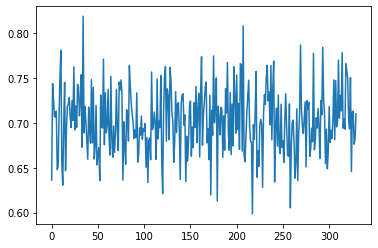

In [356]:
plt.plot(r_expect)

## Exactly solved version

### Radial Grid

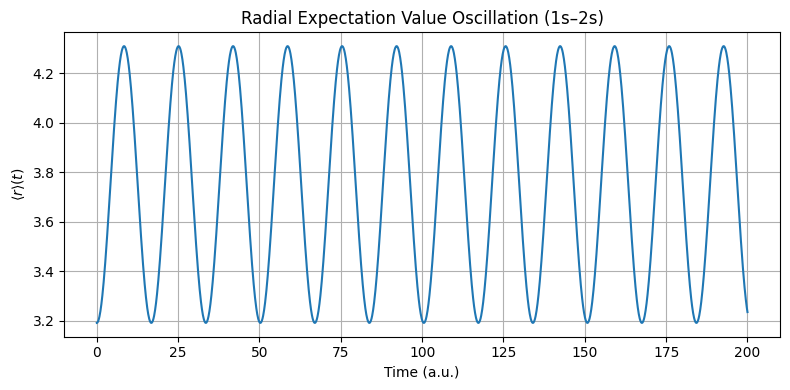

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Energies (atomic units)
# -------------------------
E1 = -0.5
E2 = -0.125
omega = E2 - E1

# -------------------------
# Radial grid
# -------------------------
r = np.linspace(0, 40, 4000)
dr = r[1] - r[0]

# -------------------------
# Hydrogen wavefunctions
# -------------------------
psi_1s = (1 / np.sqrt(np.pi)) * np.exp(-r)
psi_2s = (1 / (4 * np.sqrt(2 * np.pi))) * (2 - r) * np.exp(-r / 2)

# -------------------------
# Time-dependent wavefunction
# -------------------------
def psi_t(t):
    return (psi_1s * np.exp(-1j * E1 * t)
          + psi_2s * np.exp(-1j * E2 * t)) / np.sqrt(2)

# -------------------------
# Time grid
# -------------------------
t = np.linspace(0, 200, 2000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_t(ti)
    density = np.abs(psi)**2
    r_exp = np.sum(density * r * 4*np.pi*r**2) * dr
    r_expect.append(r_exp)

r_expect = np.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Metropolis sampling and autodiff energy gradients

In [22]:
from local_energy import get_local_energy_fn

In [21]:
def f(params, x):
    r = jnp.linalg.norm(x)
    psi = (
        (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
        + (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)
    ) / jnp.sqrt(2)
    return psi

In [23]:
f_b = jax.vmap(f, in_axes=(None, 0))

loc_energy = get_local_energy_fn(f, 1, 1)

In [24]:
le = loc_energy(params, pos)

In [25]:
jnp.mean(loc_energy(params, pos))

Array(-0.40925688+0.j, dtype=complex64)

In [26]:
## Warmup steps
pos = jax.random.uniform(key, (4200, 3))

for i in range(10):
    pos, pmove = metropolis_step(params, f_b, pos, key, 0.5)
print(pmove)

0.576619


In [60]:
le = loc_energy(params, pos)

In [61]:
jnp.mean(le)

Array(-0.39638376+0.j, dtype=complex64)

In [63]:
jnp.mean(le - jnp.mean(le))

Array(1.2800807e-08+0.j, dtype=complex64)

In [64]:
jnp.mean((le - jnp.mean(le)) ** 2)

Array(0.04612977+0.j, dtype=complex64)

In [19]:
E1 = -0.5
E2 = -0.125

def psi_t(params, x, t):
    r = jnp.linalg.norm(x)

    psi_1s = (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
    psi_2s = (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)

    return (
        psi_1s
        + psi_2s * jnp.exp(-1j * (E2-E1) * t)
    ) / jnp.sqrt(2)

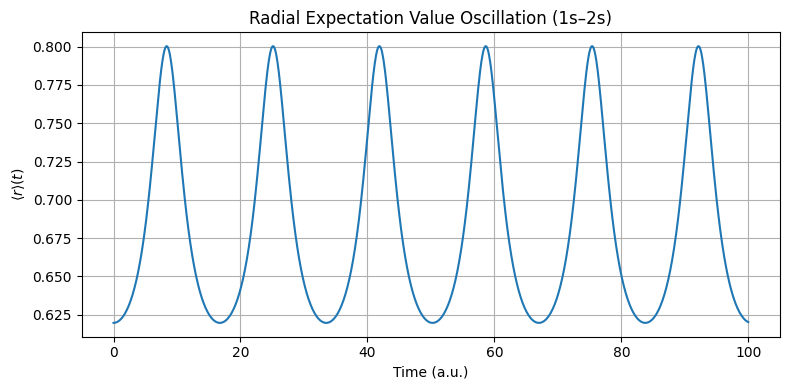

In [ ]:
#def psi_t(params, x, t):
#    return f(params, x) * jnp.exp(-1j * (E2 - E1) * t)

psi_b = jax.vmap(psi_t, in_axes=(None, 0, None))

# -------------------------
# Time grid
# -------------------------
t = jnp.linspace(0, 10.0, 1000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_b(params, pos, ti)
    density = jnp.abs(psi) ** 2
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)

r_expect = jnp.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Frequency extraction

In [24]:
import numpy as np

signal = r_expect - jnp.mean(r_expect)
dt = t[1] - t[0]

fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2

idx = np.argmax(power[1:]) + 1   # skip zero frequency
f_peak = freqs[idx]

omega_peak = 2 * np.pi * f_peak
print("Extracted ω:", omega_peak)


Extracted ω: 0.37661415


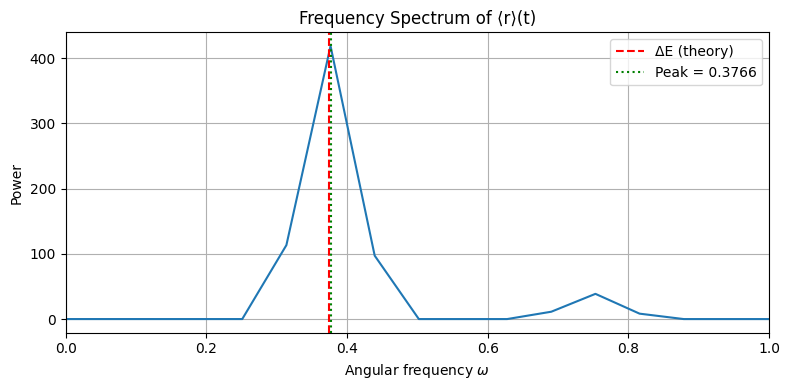

In [25]:
dt = t[1] - t[0]

signal = r_expect - np.mean(r_expect)
window = np.hanning(len(signal))

fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2
omega = 2 * np.pi * freqs

plt.figure(figsize=(8, 4))
plt.plot(omega, power)
plt.axvline(0.375, color="red", linestyle="--", label="ΔE (theory)")
plt.axvline(omega[np.argmax(power[1:]) + 1],
            color="green", linestyle=":",
            label=f"Peak = {omega[np.argmax(power[1:]) + 1]:.4f}")

plt.xlim(0, 1.0)
plt.xlabel(r"Angular frequency $\omega$")
plt.ylabel("Power")
plt.title("Frequency Spectrum of ⟨r⟩(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
